In [1]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import calendar

In [2]:
from dataset.filter import monnit_sensors_old as mso
from dataset.filter import monnit_sensors_new as msn
from dataset.filter import integration_, integration_agent

In [3]:
"""
    load train and db
"""
# 1. training_data

df_train=[]
for csvfile in glob.glob("./dataset/training_data/*.csv"):
    df=pd.read_csv(csvfile, header=None, delimiter=',')
    df.columns=['sensor','value','timestamp']
    df=df[df.sensor.isin(mso.keys())]
    df_train.append(df)
df_train=pd.concat(df_train)

for k, v in mso.items():
    df_train.loc[df_train.sensor==k, 'sensor']=v

# 2. mongoDB
with open("./dataset/mongoDB/data_db.pkl","rb") as f:
    data=pickle.load(f)
df_db=pd.DataFrame([list(datum.values())[2:5] for datum in data])
df_db.columns=['sensor','value','timestamp']
df_db=df_db[df_db.sensor.isin(mso.keys())]
df_db.timestamp=df_db.timestamp.div(1000)

for k, v in mso.items():
    df_db.loc[df_db.sensor==k, 'sensor']=v

df_total=pd.concat([df_db, df_train])
sensor_list=sorted(set(df_total.sensor))
# sensor_list

In [4]:
"""
existance dates of each sensor
"""
daybysensor={}
for sensor_ in sensor_list:

    df=df_total[df_total.sensor==sensor_]
    df_timestamps=np.array([dt.datetime.fromtimestamp(t) for t in df.timestamp.tolist()])

    dt_set=set()
    for t in df_timestamps:
        # dy, dm, dd = t.year, t.month, t.day
        dt_set.add(dt.datetime(t.year, t.month, t.day))
    
    daybysensor[sensor_]=dt_set

In [5]:
"""
    load non-monnit
"""
data=pd.read_excel(glob.glob("./dataset/*.xlsx")[0])

agentdict={i:item for i, item in enumerate(list(data.sensor))}
agentdate={item:set() for item in data.sensor}

for item in data.columns[1:]:
    dt_=dt.datetime.strptime(item, "%y/%m/%d")
    bin_=list(data[item])
    for i, item in enumerate(bin_):
        if item==1:
            agentdate[agentdict[i]].add(dt_)

In [6]:
"""
    load imonnit
"""
imonnit_dict={}
for parent_ in glob.glob("./dataset/imonnit/*"):
    file_=glob.glob("{}/*.npy".format(parent_))[0]
    sensor=file_.split("/")[-1].split(".")[0]
    timestamp_col=np.load(file_)[:,0]
    dts_=[dt.datetime.fromtimestamp(float(item)/1000.) for item in timestamp_col]
    dateset=set([dt.datetime(item.year, item.month, item.day) for item in dts_])
    if sensor not in msn.keys():
        print(sensor)
        raise ValueError
    imonnit_dict[msn[sensor]]=dateset

In [11]:
agg_={**daybysensor, **agentdate, **imonnit_dict}
agg={}
for k, v in agg_.items():
    if integration_[k] in agg.keys():
        agg[integration_[k]]=agg[integration_[k]]|v
    else:
        agg[integration_[k]]=v

sensors, dates, exists = [], [], []

for k, v in agg.items():
    start_date=dt.datetime(2017, 1, 1)
    end_date=dt.datetime(2021, 6, 30)

    date_bucket=[]
    exist_bucket=[]
    while start_date!=end_date:
        date_bucket.append(start_date)
        if start_date not in v:
            exist_bucket.append(0)
        else:
            exist_bucket.append(1)
        start_date+=dt.timedelta(days=1)
    sensors+=[k for i in range(len(date_bucket))]
    dates+=date_bucket
    exists+=exist_bucket

d={'sensor': sensors, 'day': dates, 'exist': exists}
df=pd.DataFrame(data=d)

df_pivot=df.pivot('sensor', 'day', 'exist').fillna(0)

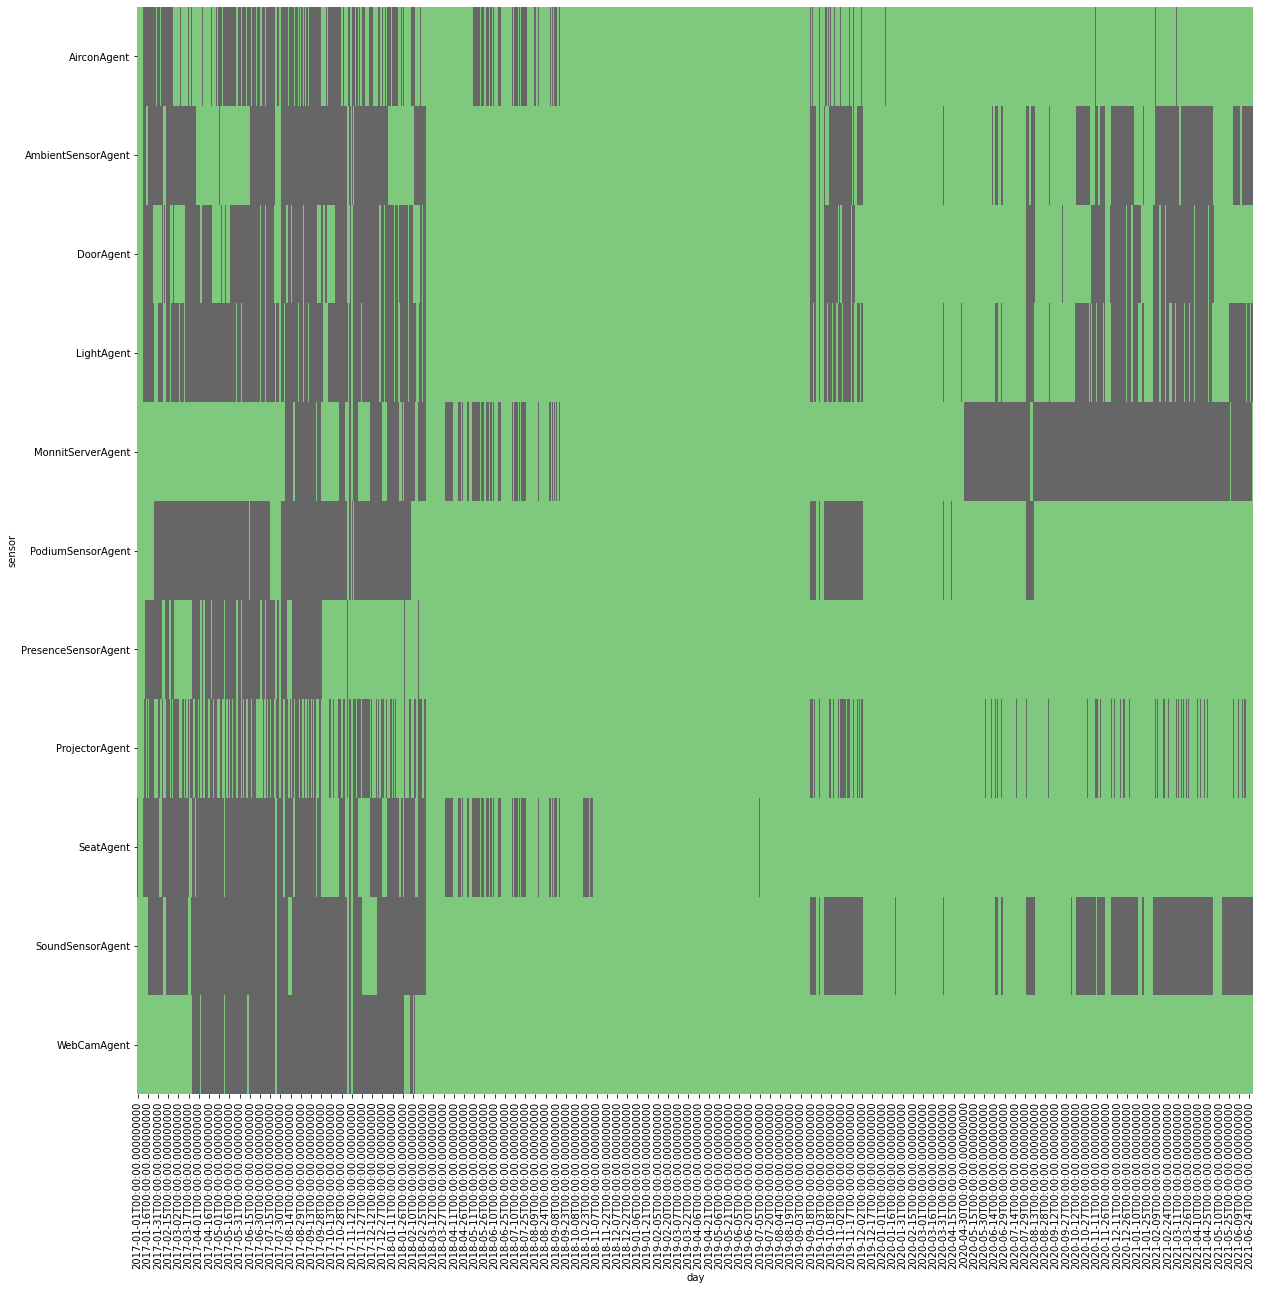

In [12]:
fig, ax = plt.subplots(figsize=(20,20))
ax=sns.heatmap(df_pivot, vmin=0, vmax=1, cbar=False, cmap='Accent')
# x_dates=(df['day']).dt.strftime('%Y-%m').sort_values().unique(); print(x_dates)
plt.savefig("./graphs/heatmap_intersection_agent.png", dpi=300)

In [9]:
l=[]
cols=sorted([item.to_pydatetime() for item in df_pivot.columns])
min_dt, max_dt=cols[0], cols[-1]
curr_dt=min_dt
while curr_dt!=max_dt:
    if curr_dt not in cols:
        l.append((0,curr_dt))
    else:
        l.append((sum(df_pivot[curr_dt].fillna(0)), curr_dt))
    curr_dt+=dt.timedelta(days=1)

# xaxis=[item[1] for item in l]
# yaxis=[item[0] for item in l]


for j in range(2017, 2022):
    year_=j
    for i in range(12):
        
        start_date=dt.datetime(year_, 1+i, 1)
        day_month=calendar.monthrange(year_, 1+i)[1]
        end_date=dt.datetime(year_, 1+i, day_month)
        l_=[item for item in l if item[1]>=start_date and item[1]<=end_date]
        xaxis=[item[1] for item in l_]
        yaxis=[item[0] for item in l_]

        # fig, ax = plt.subplots(figsize=(10,10))
        plt.bar(xaxis, yaxis, color='g')
        plt.axhline(y=len(agg.keys()))
        # xt=ax.get_yticks(); xt=xt[1:-1]
        # xt=np.append(xt, [max(yaxis), len(agg.keys())])
        # ax.set_yticks(xt)
        plt.xticks(rotation=60)
        plt.title("{}-{}".format(year_, 1+i))
        plt.savefig("./graphs/Intersection/{}/intersection_count_{}_{}.png".format(year_, year_, 1+i), dpi=300)
        plt.clf()

    


<Figure size 432x288 with 0 Axes>

In [12]:
# (count, date)
list__=sorted([(yaxis[i], "{}-{}-{}".format(xaxis[i].year, xaxis[i].month, xaxis[i].day)) for i in range(len(xaxis))], reverse=True)
print(list__[:5])

[(11.0, '2017-9-8'), (11.0, '2017-9-4'), (11.0, '2017-9-20'), (11.0, '2017-9-18'), (11.0, '2017-9-15')]
